In [37]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data


## Data preparation

In [38]:
df = pd.read_csv('data.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [39]:
df.shape

(10886, 17)

In [40]:
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [41]:
df.drop(columns=['dteday', 'instant'], inplace=True)

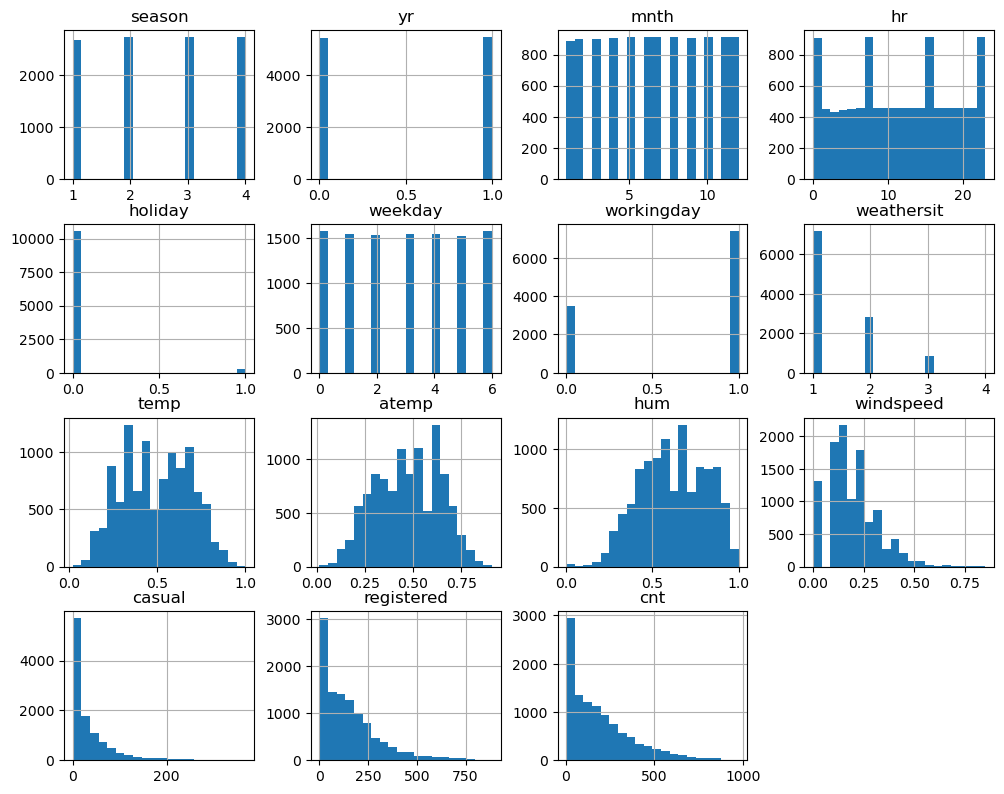

In [42]:
df.hist(bins=20, figsize=(12, 12), layout=(5, 4))
plt.show()

## Train model

In [43]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 2*num_hidden)
        self.act_fn = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(2*num_hidden, 3*num_hidden)
        self.linear3 = nn.Linear(3*num_hidden, num_hidden)
        self.linear4 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.linear4(x)
        return x

In [147]:
train=df.sample(frac=1, random_state=200)
test=df.drop(train.index)

In [98]:
def rmsle(y_true,y_pred):
    n = len(y_true)
    msle = np.mean([(np.log(max(y_pred[i],0) + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

In [148]:
import torch.optim as optim

model = SimpleClassifier(12, 250, 1)
crit = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


In [149]:
import torch.utils.data as data

train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-3]), torch.from_numpy(train.values[:,-1]))
test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,:-3]), torch.from_numpy(test.values[:,-1]))


In [150]:
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [151]:
size_tmp = next(iter(train_data_loader))[0].shape[0]*len(train_data_loader)

11008

## Predictions

In [152]:
for epoch in range(150):  # loop over the dataset multiple times

    sum_loss = 0.0
    for data in train_data_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0], data[1]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        preds = model(inputs.float())
        preds = preds.squeeze(dim=1)
        
        # preds = torch.sigmoid(preds)
        loss = crit(preds, labels.float())
        loss.backward()
        optimizer.step()

        sum_loss += loss
    
    print('Epoch:' , epoch + 1, '-', sum_loss/size_tmp)

Epoch: 1 - tensor(218.5152, grad_fn=<DivBackward0>)
Epoch: 2 - tensor(151.2890, grad_fn=<DivBackward0>)
Epoch: 3 - tensor(130.2079, grad_fn=<DivBackward0>)
Epoch: 4 - tensor(117.0884, grad_fn=<DivBackward0>)
Epoch: 5 - tensor(112.1089, grad_fn=<DivBackward0>)
Epoch: 6 - tensor(103.9420, grad_fn=<DivBackward0>)
Epoch: 7 - tensor(98.6958, grad_fn=<DivBackward0>)
Epoch: 8 - tensor(93.8562, grad_fn=<DivBackward0>)
Epoch: 9 - tensor(95.5391, grad_fn=<DivBackward0>)
Epoch: 10 - tensor(91.3633, grad_fn=<DivBackward0>)
Epoch: 11 - tensor(85.5293, grad_fn=<DivBackward0>)
Epoch: 12 - tensor(82.0414, grad_fn=<DivBackward0>)
Epoch: 13 - tensor(79.1004, grad_fn=<DivBackward0>)
Epoch: 14 - tensor(77.1428, grad_fn=<DivBackward0>)
Epoch: 15 - tensor(71.1978, grad_fn=<DivBackward0>)
Epoch: 16 - tensor(66.6780, grad_fn=<DivBackward0>)
Epoch: 17 - tensor(69.8331, grad_fn=<DivBackward0>)
Epoch: 18 - tensor(63.6494, grad_fn=<DivBackward0>)
Epoch: 19 - tensor(59.5136, grad_fn=<DivBackward0>)
Epoch: 20 - ten

In [166]:
import torch.utils.data as data

test_df = pd.read_csv('evaluation_data.csv')
test_df.drop(columns=['dteday'], inplace=True)

test_dataset = data.TensorDataset(torch.from_numpy(test_df.values))


In [169]:
y_pred = list()

with torch.no_grad(): 
    for data_inputs in test_df.values:
        preds = model(torch.from_numpy(data_inputs).float())
        y_pred.append(np.abs(float(preds)))

        print(np.abs(float(preds)))

pd.DataFrame(y_pred).to_csv("wynik.csv", index=False, header=None)


7.4429450035095215
8.700414657592773
2.1036217212677
5.76492977142334
8.076839447021484
15.409822463989258
32.57561492919922
75.42463684082031
126.30308532714844
71.24380493164062
64.5281982421875
49.96177291870117
56.4525032043457
57.98546600341797
74.58335876464844
72.32281494140625
111.50941467285156
100.2498779296875
160.77867126464844
105.26483154296875
61.42771911621094
52.362186431884766
25.959251403808594
21.46872901916504
16.930538177490234
4.663355827331543
2.3900766372680664
4.708300590515137
5.7120041847229
21.024078369140625
19.873706817626953
71.34638977050781
184.3651123046875
106.45716857910156
61.751407623291016
71.61714172363281
78.45726013183594
57.80145263671875
54.48183822631836
62.1073112487793
95.04551696777344
114.47647094726562
111.92938232421875
78.99298095703125
59.72381591796875
30.84722137451172
51.18675994873047
38.274932861328125
22.92450523376465
23.149585723876953
5.810269355773926
6.114206314086914
10.736639022827148
12.527013778686523
15.0665836334228